In [48]:
import numpy as np
import gym
import math
import random
from collections import namedtuple
from itertools import count
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [49]:
env = gym.make('CartPole-v1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.position = 0
    
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        
        self.position += 1
        if self.position == self.capacity:
            self.position = 0
            
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
        

In [51]:
class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()              
        self.first = nn.Linear(4, 320)
        self.output = nn.Linear(320, outputs)

    def forward(self, x):
        x = F.relu(self.first(x))
        x = self.output(x)
        return x

In [52]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

In [53]:
n_actions = env.action_space.n
steps_done = 0
episode_durations = list()

net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
memory = ReplayMemory(MEMORY_SIZE)

In [54]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [55]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)

In [56]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))
    
    batch_state = torch.cat(batch.state)
    batch_action = torch.cat(batch.action)
    batch_reward = torch.cat(batch.reward)
    batch_next_state = torch.cat(batch.next_state)

    state_action_values = net(batch_state).gather(1, batch_action)
    next_values = target_net(batch_next_state).max(1)[0].detach()
    expected_state_action_values = (next_values * GAMMA) + batch_reward

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Complete epoch 0 54.02
Complete epoch 1 150.32
Complete epoch 2 424.805
Complete epoch 3 433.07
Complete epoch 4 442.66
Complete epoch 5 442.66


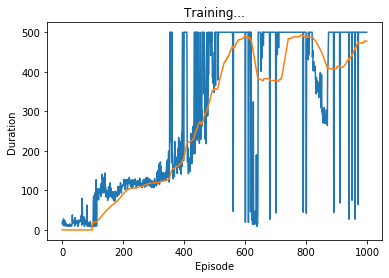

In [57]:
num_episodes = [200, 200, 200, 200, 200, 0]
for epoch in range(len(num_episodes)):
    for i_episode in range(num_episodes[epoch]):
        state = torch.tensor([env.reset()], dtype=torch.float, device=device)
        for t in count():
            action = select_action(state)
            if epoch == len(num_episodes) - 1:
                env.render()
            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.tensor([next_state], dtype=torch.float, device=device)
            if done and t + 1 != 500:
                reward = -10
            reward = torch.tensor([reward], dtype=torch.float, device=device)

            memory.push(state, action, next_state, reward)
            state = next_state
            optimize_model()

            if done:
                episode_durations.append(t + 1)
                break
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(net.state_dict())

    print('Complete epoch {}'.format(epoch), np.mean(episode_durations[-200:]))
    
env.close()
plot_durations()
plt.show()